# Tunable MZI

This example shows how to set up a parameter-dependent model to quickly run complex simulations under different conditions.

We will create a simple, semi-analytical model for a thermo-optic Mach-Zehnder interferometer and run circuit-level simulations with varying external voltage signals applied.
The geometry is imported from an existing GDSII layout to also show how to set up models and ports in this case.

We use the open source [LNOI400 PDK](https://pypi.org/project/luxtelligence-lnoi400-forge/) from [Luxtelligence](https://luxtelligence.ai/).

In [1]:
import luxtelligence_lnoi400_forge as lxt
import matplotlib.pyplot as plt
import numpy as np
import photonforge as pf
import photonforge.live_viewer as live_viewer
import tidy3d as td

td.config.logging_level = "ERROR"
viewer = live_viewer.LiveViewer()

Starting live viewer at http://localhost:5001


We start by defining a few defaults, including the Luxtelligence PDK, that will be used throughout the design.

In [2]:
tech = lxt.lnoi400()
pf.config.default_technology = tech

# We are only interested in the fundamental TE mode
port_spec = tech.ports["RWG1000"]
port_spec.num_modes = 1

pf.config.default_kwargs = {
    "port_spec": port_spec,
    "radius": 75,
    "euler_fraction": 0.5,
}

wavelengths = np.linspace(1.5, 1.6, 21)

## Phase shifter

We will use the phase shifter designed in the [Quantum Chip](Quantum_Chip.ipynb) example as a starting point, loading it from the GDSII file exported in that example.

In [3]:
phase_shifter = pf.load_layout("phase_shifter.gds")["phase_shifter"]
viewer(phase_shifter)

If you load gds, you don't have ports and models as only layout information is present in this gds file.

In [4]:
print("Ports:", phase_shifter.ports)
print("Models:", phase_shifter.models)

Ports: {}
Models: {}


So, let's add ports and we can use port auto-detection feature in PhotonForge.
We pass the port specification to the detection function because we already know the types of port our phase shifter was designed with.

In [5]:
phase_shifter.add_port(phase_shifter.detect_ports([port_spec]))
viewer(phase_shifter)

In [6]:
heater_length = (
    phase_shifter.ports["P1"].center[0] - phase_shifter.ports["P0"].center[0]
)
print(f"Heater length is {heater_length :.1f} μm")

Heater length is 100.0 μm


### Creating a heater model

For our semi-analytical model we'll need the effective index for the phase-shifter waveguide.

Loading cached simulation from .tidy3d/pf_cache/KDV/ms_info-3HNXCQWPMPLGBXUBWQIVVYFDDPNVF3BUJ6TTQJQEX7IQGQUL4AJQ.json.


Progress: 100%


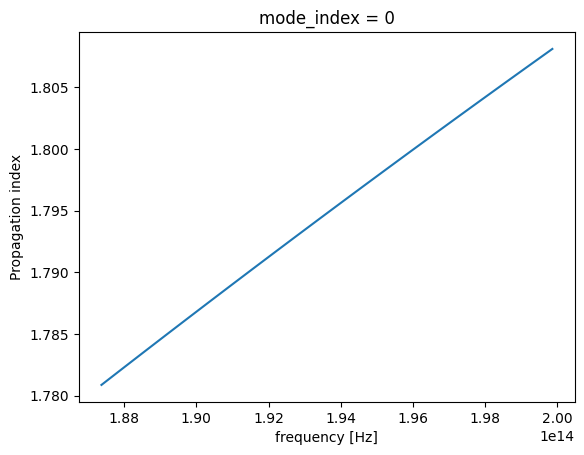

In [7]:
mode_solver = pf.port_modes(port_spec, pf.C_0 / wavelengths, group_index=True)
_ = mode_solver.data.n_eff.plot()

PhotonForge supports parametric models similarly to parametric components.
Let's say we have measured data or [simulation data](https://www.flexcompute.com/tidy3d/examples/notebooks/MetalHeaterPhaseShifter/) that tells us the index change we expect from a given voltage signal.

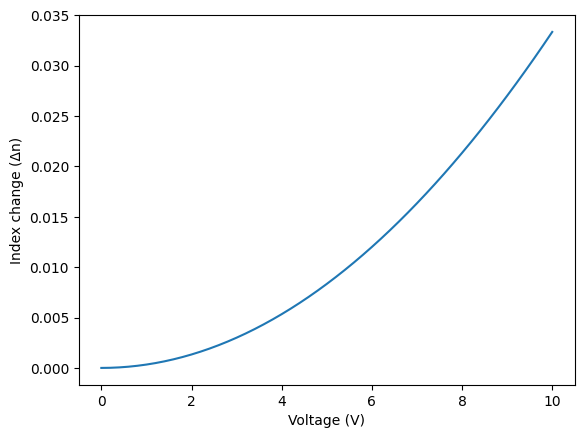

In [8]:
def index_change(voltage, resistance, coefficient):
    return coefficient * voltage**2 / resistance


v = np.linspace(0, 10, 51)
dn = index_change(v, 3, 1e-3)

plt.plot(v, dn)
plt.xlabel("Voltage (V)")
_ = plt.ylabel("Index change (Δn)")

Now we create a parametric component that depends on this custom model for phase shift.

In [9]:
n_complex = mode_solver.data.n_complex.values.T


def index(voltage, resistance=3, coefficient=1e-3):
    dn = index_change(voltage, resistance, coefficient)
    return n_complex + dn


# Set the default condition to 0 V
thermal_model = pf.WaveguideModel(n_complex=index(0))
_ = phase_shifter.add_model(thermal_model, "Waveguide")

We can see the parametric model working by computing the S matrix with varying voltages:

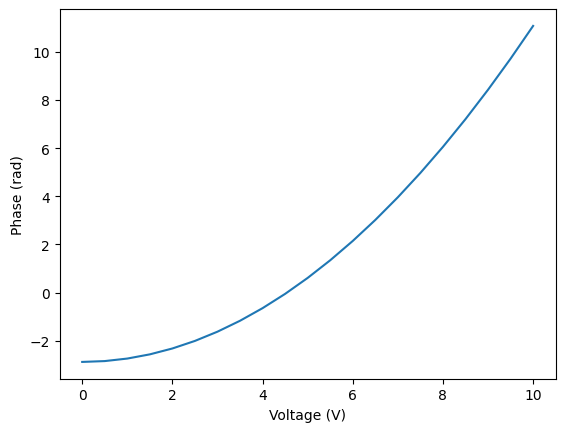

In [10]:
voltages = np.linspace(0, 10, 21)
phases = []
for voltage in voltages:
    thermal_model.update(n_complex=index(voltage))
    s = phase_shifter.s_matrix(pf.C_0 / wavelengths, show_progress=False)
    phases.append(np.angle(s["P0@0", "P1@0"][0]))

# Let's reset the model, just in case
thermal_model.update(n_complex=index(0))

plt.plot(voltages, np.unwrap(phases))
plt.xlabel("Voltage (V)")
_ = plt.ylabel("Phase (rad)")

## MMI

Let's load this PDK component from Luxtelligence's open source PDK that we have implemented in PhotonForge.

In [11]:
mmi = lxt.component.mmi2x2(
    tidy3d_model_kwargs={
        "port_symmetries": [
            ("P1", "P0", "P3", "P2"),
            ("P2", "P3", "P0", "P1"),
            ("P3", "P2", "P1", "P0"),
        ]
    }
)

viewer(mmi)

When setting up port symmetries, it is possible to test them with the [test_port_symmetries](../_autosummary/photonforge.Tidy3DModel.rst#photonforge.Tidy3DModel.test_port_symmetries) method (and a coarser mesh, otherwise, we'd just run without symmetries):

In [12]:
assert mmi.active_model.test_port_symmetries(
    mmi, frequencies=pf.C_0 / wavelengths, grid_spec=8
)

Loading cached simulation from .tidy3d/pf_cache/ZGS/fdtd_info-KFJUNB3W7OJ2A2HT6BTJFHIFZ7IEKS4LHQ3ZUVCV2N3GWZ7NK5EA.json.
Loading cached simulation from .tidy3d/pf_cache/ZGS/fdtd_info-VWIEYL3TBO3AFQRWYUKILVUIZWTWK77LAWZULHZIOMBTTZYTCM2A.json.


Loading cached simulation from .tidy3d/pf_cache/ZGS/fdtd_info-OFTQHUSVDFXF6NVIQTG4OOOU4ZB73O52LOOHI77WT4L3N63YBWTQ.json.
Loading cached simulation from .tidy3d/pf_cache/ZGS/fdtd_info-Q33MADRRGX2ATTKBP2ZHNZNSKXYABMRAG6MCINAM2QH63BTCFRLQ.json.
Progress: 100% 
Progress: 100% 


We can quickly inspect the splitting ratio.

Loading cached simulation from .tidy3d/pf_cache/ZGS/fdtd_info-VQKU4YBEJP3UXGMRO26YLJ2B6VUYODN27TVIELRGC3BSSXCRZBBA.json.
Progress: 100% 


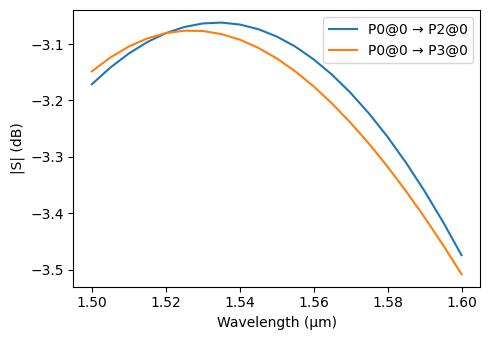

In [13]:
s_matrix_mmi = mmi.s_matrix(pf.C_0 / wavelengths)

_ = pf.plot_s_matrix(
    s_matrix_mmi, input_ports=["P0"], output_ports=["P2", "P3"], y="dB"
)

## Building tunable MZI

In [14]:
netlist = {
    "name": "Tunable_MZI",
    "instances": {
        "mmi1": mmi,
        "ps0": {"component": phase_shifter, "origin": (280, -75)},
        "ps1": {"component": phase_shifter, "origin": (280, 75)},
        "mmi2": {"component": mmi, "origin": (580, 0)},
    },
    # automatic routing
    "routes": [
        (("mmi1", "P2"), ("ps0", "P0"), pf.parametric.route_s_bend),
        (("mmi1", "P3"), ("ps1", "P0"), pf.parametric.route_s_bend),
        (("mmi2", "P1"), ("ps1", "P1"), pf.parametric.route_s_bend),
        (("mmi2", "P0"), ("ps0", "P1"), pf.parametric.route_s_bend),
    ],
    "ports": [("mmi1", "P0"), ("mmi1", "P1"), ("mmi2", "P2"), ("mmi2", "P3")],
    # Model for the full circuit
    "models": [(pf.CircuitModel(), "Circuit")],
}

mzi = pf.component_from_netlist(netlist)
viewer(mzi)

The S matrix for any voltage can be computed in a similar fashion to what we did before, by using model updates.
However, if we just change `thermal_model` directly, it will affect *both arms* of the MZI, since they use the same model.

The circuit model comes handy in this case: it can update our models based on which *reference* we are computing, so that each phase shifter is updated independently just during that reference's computation.
For that we will use the `updates` argument to the circuit model's [start](../_autosummary/photonforge.CircuitModel.rst#photonforge.CircuitModel.start) method, which is passed through the [s_matrix](../_autosummary/photonforge.Component.rst#photonforge.Component.s_matrix) `model_kwargs` argument.

To use reference-based updates, we have to *select* a reference in our component hierarchy.
In this case, we can select by name (references to "phase_shifter", which is the name of the component we loaded from the GDSII) and index (0 and 1 for the 2 references).

Loading cached simulation from .tidy3d/pf_cache/H6S/ms_info-LAS7MOUZIBO2CUWED7GHXLQH5PITHTNNZAGMT3FYNVNBWT7JDP3Q.json.


Loading cached simulation from .tidy3d/pf_cache/2WY/ms_info-C6OV5TUBD2MEX2KGWY3LNIQVYER6TALT37DN5YZZLVJO6AABMBPQ.json.
Progress: 100% 


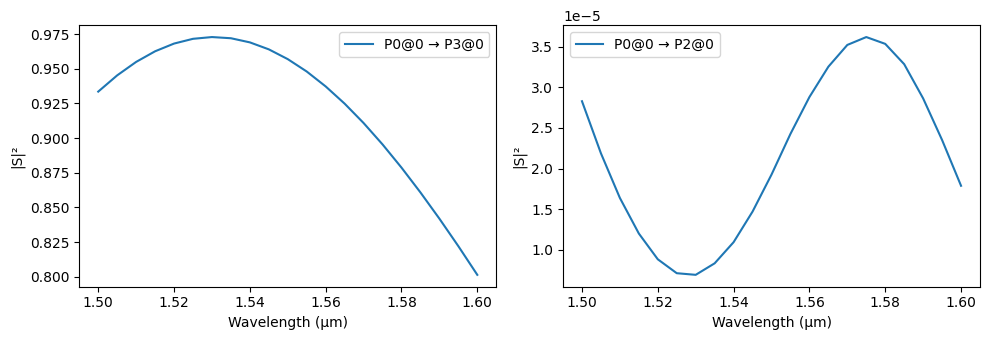

In [15]:
updates = {
    ("phase_shifter", 0): {"model_updates": {"n_complex": index(0)}},
    ("phase_shifter", 1): {"model_updates": {"n_complex": index(0)}},
}
s_matrix = mzi.s_matrix(pf.C_0 / wavelengths, model_kwargs={"updates": updates})
_ = pf.plot_s_matrix(s_matrix, input_ports=["P0"], output_ports=["P2", "P3"])

Progress: 100% 


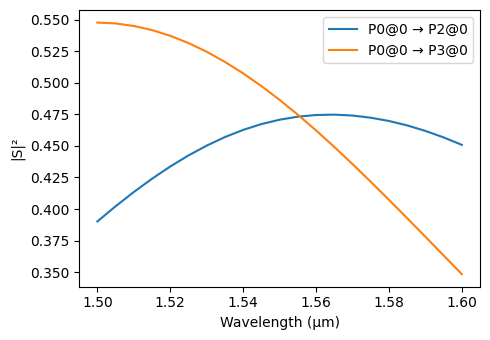

In [16]:
updates = {
    ("phase_shifter", 0): {"model_updates": {"n_complex": index(6)}},
    ("phase_shifter", 1): {"model_updates": {"n_complex": index(1)}},
}
s_matrix = mzi.s_matrix(pf.C_0 / wavelengths, model_kwargs={"updates": updates})
_ = pf.plot_s_matrix(s_matrix, input_ports=["P0"], output_ports=["P2", "P3"])

Let's make an interactive plot to see how S-matrix of the circuit changes when we apply voltage to different heater arms

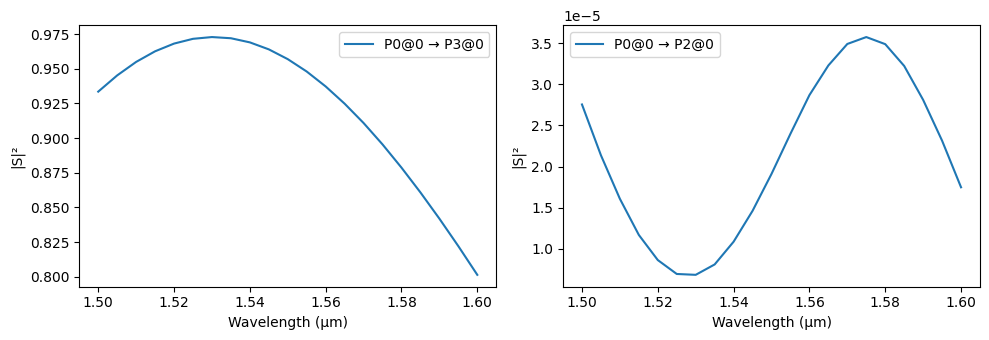

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='voltage0', max=20.0), Float…

In [17]:
from ipywidgets import FloatSlider, interactive


def update_and_plot(voltage0, voltage1):
    updates = {
        ("phase_shifter", 0): {"model_updates": {"n_complex": index(voltage0)}},
        ("phase_shifter", 1): {"model_updates": {"n_complex": index(voltage1)}},
    }
    s_matrix = mzi.s_matrix(
        pf.C_0 / wavelengths,
        model_kwargs={"updates": updates},
        show_progress=False,
    )
    pf.plot_s_matrix(s_matrix, input_ports=["P0"], output_ports=["P2", "P3"])


freqs = s_matrix.frequencies
np.abs(s_matrix[("P0@0", "P3@0")][len(freqs) // 2]) ** 2


interactive(
    update_and_plot,
    voltage0=FloatSlider(min=0, max=20, continuous_update=False),
    voltage1=FloatSlider(min=0, max=20, continuous_update=False),
)

We can also make the usual plot of how the power output of the MZI changes as the heater voltage is increased:

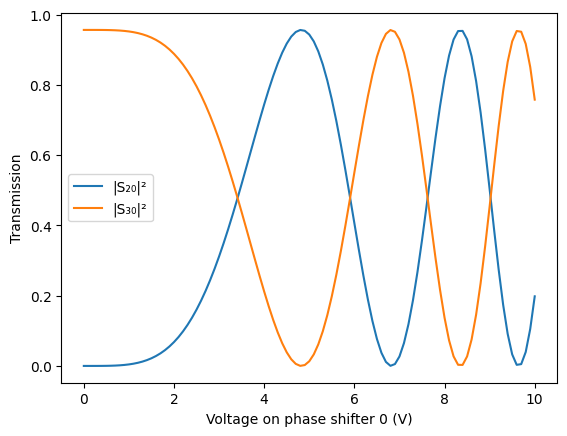

In [17]:
voltages = np.linspace(0, 10, 101)
transmission = np.zeros((voltages.size, 2))
k = len(wavelengths) // 2  # Look at central wavelength

for i, v in enumerate(voltages):
    updates = {("phase_shifter", 0): {"model_updates": {"n_complex": index(v)}}}
    s = mzi.s_matrix(
        pf.C_0 / wavelengths, model_kwargs={"updates": updates}, show_progress=False
    )
    transmission[i, 0] = np.abs(s[("P0@0", "P2@0")][k]) ** 2
    transmission[i, 1] = np.abs(s[("P0@0", "P3@0")][k]) ** 2

# Plot results
plt.plot(voltages, transmission)
plt.xlabel("Voltage on phase shifter 0 (V)")
plt.ylabel("Transmission")
plt.legend(["|S₂₀|²", "|S₃₀|²"])
plt.show()